In [209]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

In [210]:
def display_level_image(tile_dim, level, tile_name_to_image):
    level_image = Image.new("RGB", (tile_dim[1] * len(level[0]), tile_dim[1] * len(level) ))
    for row in range(len(level)):
        for col in range(len(level[0])):
            level_image.paste(tile_name_to_image[level[row][col]],(col * tile_dim[0], row * tile_dim[1], (col+1) * tile_dim[0], (row +1) *tile_dim[1]))
    
    plt.figure()
    plt.imshow(level_image)
    plt.show()

def propose(grid):
    rows = len(grid)
    cols = len(grid[0])
    choices = [ i for i in range(rows * cols)]
    entries = random.sample(choices, 2)
    while grid[entries[0] // cols][entries[0] % cols] == grid[entries[1] // cols][entries[1] % cols]:
        entries = random.sample(choices, 2)

    return [(entries[0] // cols, entries[0] % cols), (entries[1] // cols, entries[1] % cols)]

def calculate_liklihood(grid, position, adjacency_frequencies, occurences):
    tile_val = grid[position[0]][position[1]]
    prob = 1
    
    for offset in [(0,1), (1,0), (0,-1), (-1,0)]:
        row = position[0] + offset[0]
        col = position[1] + offset[1]
        if row < 0 or row >= len(grid) or col < 0 or col >= len(grid[0]):
            prob *= occurences[tile_val]/sum(occurences.values())
            continue
        offset_tile_val = grid[row][col]
        adjacencies = adjacency_frequencies[offset_tile_val]
        total = sum([count for count in adjacencies.values()])
        if tile_val in adjacencies:
            adjacency_count = adjacencies[tile_val]
        else:
            adjacency_count = 0
        prob *= adjacency_count / total

    return prob

def accept(grid, tile_one_pos, tile_two_pos, adjacency_frequencies, occurences):
    before_grid = deepcopy(grid)
    before_likelihood = 1
    for pos in [tile_one_pos, tile_two_pos]:
        for offset in [(0,0), (0,1), (1,0), (0,-1), (-1,0)]:
            row = pos[0] + offset[0]
            col = pos[1] + offset[1]
            if row < 0 or row >= len(grid) or col < 0 or col >= len(grid[0]):
                continue
            before_likelihood *= calculate_liklihood(before_grid, (row, col), adjacency_frequencies, occurences)
            
    after_grid = deepcopy(grid)
    temp = after_grid[tile_one_pos[0]][tile_one_pos[1]]
    after_grid[tile_one_pos[0]][tile_one_pos[1]] = after_grid[tile_two_pos[0]][tile_two_pos[1]]
    after_grid[tile_two_pos[0]][tile_two_pos[1]] = temp
    
    after_likelihood = 1
    for pos in [tile_one_pos, tile_two_pos]:
        for offset in [(0,0), (0,1), (1,0), (0,-1), (-1,0)]:
            row = pos[0] + offset[0]
            col = pos[1] + offset[1]
            if row < 0 or row >= len(grid) or col < 0 or col >= len(grid[0]):
                continue
            after_likelihood *= calculate_liklihood(after_grid, (row, col), adjacency_frequencies, occurences)
    if before_likelihood == after_likelihood == 0:
        after_likelihood = 0.5
        before_likelihood = 0.5
        
    should_accept = random.choices([False, True], weights=[before_likelihood, after_likelihood])[0]

    if should_accept:
        return after_grid
    else:
        return before_grid

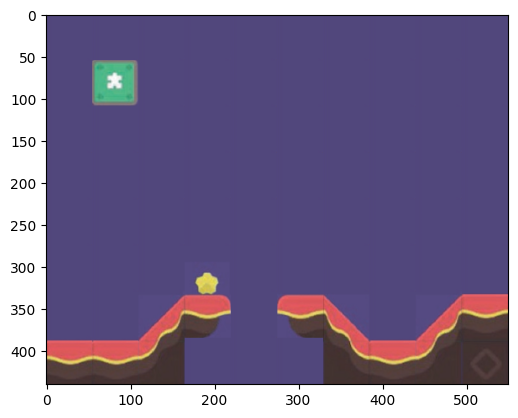

In [211]:
tile_name_to_image = {}
tiles = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
for tile in tiles:
    tile_name_to_image[tile] = Image.open(f'tiles/{tile}.png')
example_level = [
    ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
    ["A", "B", "A", "A", "A", "A", "A", "A", "A", "A"],
    ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
    ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
    ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
    ["A", "A", "A", "G", "A", "A", "A", "A", "A", "A"],
    ["A", "A", "E", "F", "A", "H", "I", "A", "E", "C"],
    ["C", "C", "D", "A", "A", "A", "J", "C", "D", "K"]
]
tile_dim = tile_name_to_image["A"].size

display_level_image(tile_dim, example_level, tile_name_to_image)

In [212]:
tile_adjacency_frequencies = {}
occurences = {}
for row in range(len(example_level)):
    for col in range(len(example_level[0])):
        tile = example_level[row][col]
        if tile in occurences:
            occurences[tile] += 1
        else:
            occurences[tile] = 1
        
        if tile in tile_adjacency_frequencies:
            tile_adjacency_frequency = tile_adjacency_frequencies[tile]
        else:
            tile_adjacency_frequency = {}

        for tile_offset in [(0,-1), (1,0), (0,1), (-1,0)]:
            if (row + tile_offset[1]) < 0 or (row + tile_offset[1]) >= len(example_level) or (col + tile_offset[0]) < 0 or (col + tile_offset[0]) >= len(example_level[0]):
                continue
            adjacent_tile = example_level[row + tile_offset[1]][col + tile_offset[0]]

            if adjacent_tile in tile_adjacency_frequency:
                tile_adjacency_frequency[adjacent_tile] += 1
            else:
                tile_adjacency_frequency[adjacent_tile] = 1
        
        tile_adjacency_frequencies[tile] = tile_adjacency_frequency
    
print(tile_adjacency_frequencies)
print(occurences)

{'A': {'A': 210, 'B': 4, 'G': 3, 'E': 4, 'H': 3, 'I': 2, 'C': 4, 'F': 2, 'D': 1, 'J': 1}, 'B': {'A': 4}, 'G': {'A': 3, 'F': 1}, 'E': {'A': 4, 'F': 1, 'D': 2, 'C': 1}, 'F': {'G': 1, 'A': 2, 'E': 1}, 'H': {'A': 3, 'I': 1}, 'I': {'A': 2, 'J': 1, 'H': 1}, 'C': {'A': 4, 'K': 1, 'E': 1, 'C': 2, 'D': 2, 'J': 1}, 'D': {'E': 2, 'A': 1, 'C': 2, 'K': 1}, 'J': {'I': 1, 'C': 1, 'A': 1}, 'K': {'C': 1, 'D': 1}}
{'A': 65, 'B': 1, 'G': 1, 'E': 2, 'F': 1, 'H': 1, 'I': 1, 'C': 4, 'D': 2, 'J': 1, 'K': 1}


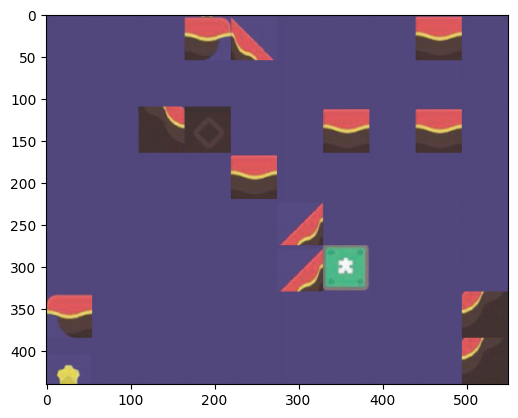

In [213]:
flat_list = [item for sublist in example_level for item in sublist]
random.shuffle(flat_list)
rows, cols = len(example_level), len(example_level[0])
grid = [flat_list[i * cols:(i + 1) * cols] for i in range(rows)]


display_level_image(tile_dim, grid, tile_name_to_image)

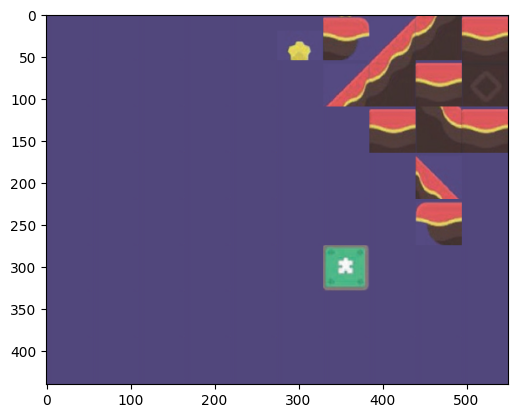

In [218]:
for i in range(100000):
    tiles_to_swap = propose(grid)
    grid = accept(grid, tiles_to_swap[0], tiles_to_swap[1], tile_adjacency_frequencies, occurences)
display_level_image(tile_dim, grid, tile_name_to_image)